In [39]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [40]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
print(data.shape)


(1338, 7)


In [42]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [43]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [44]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [45]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [46]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

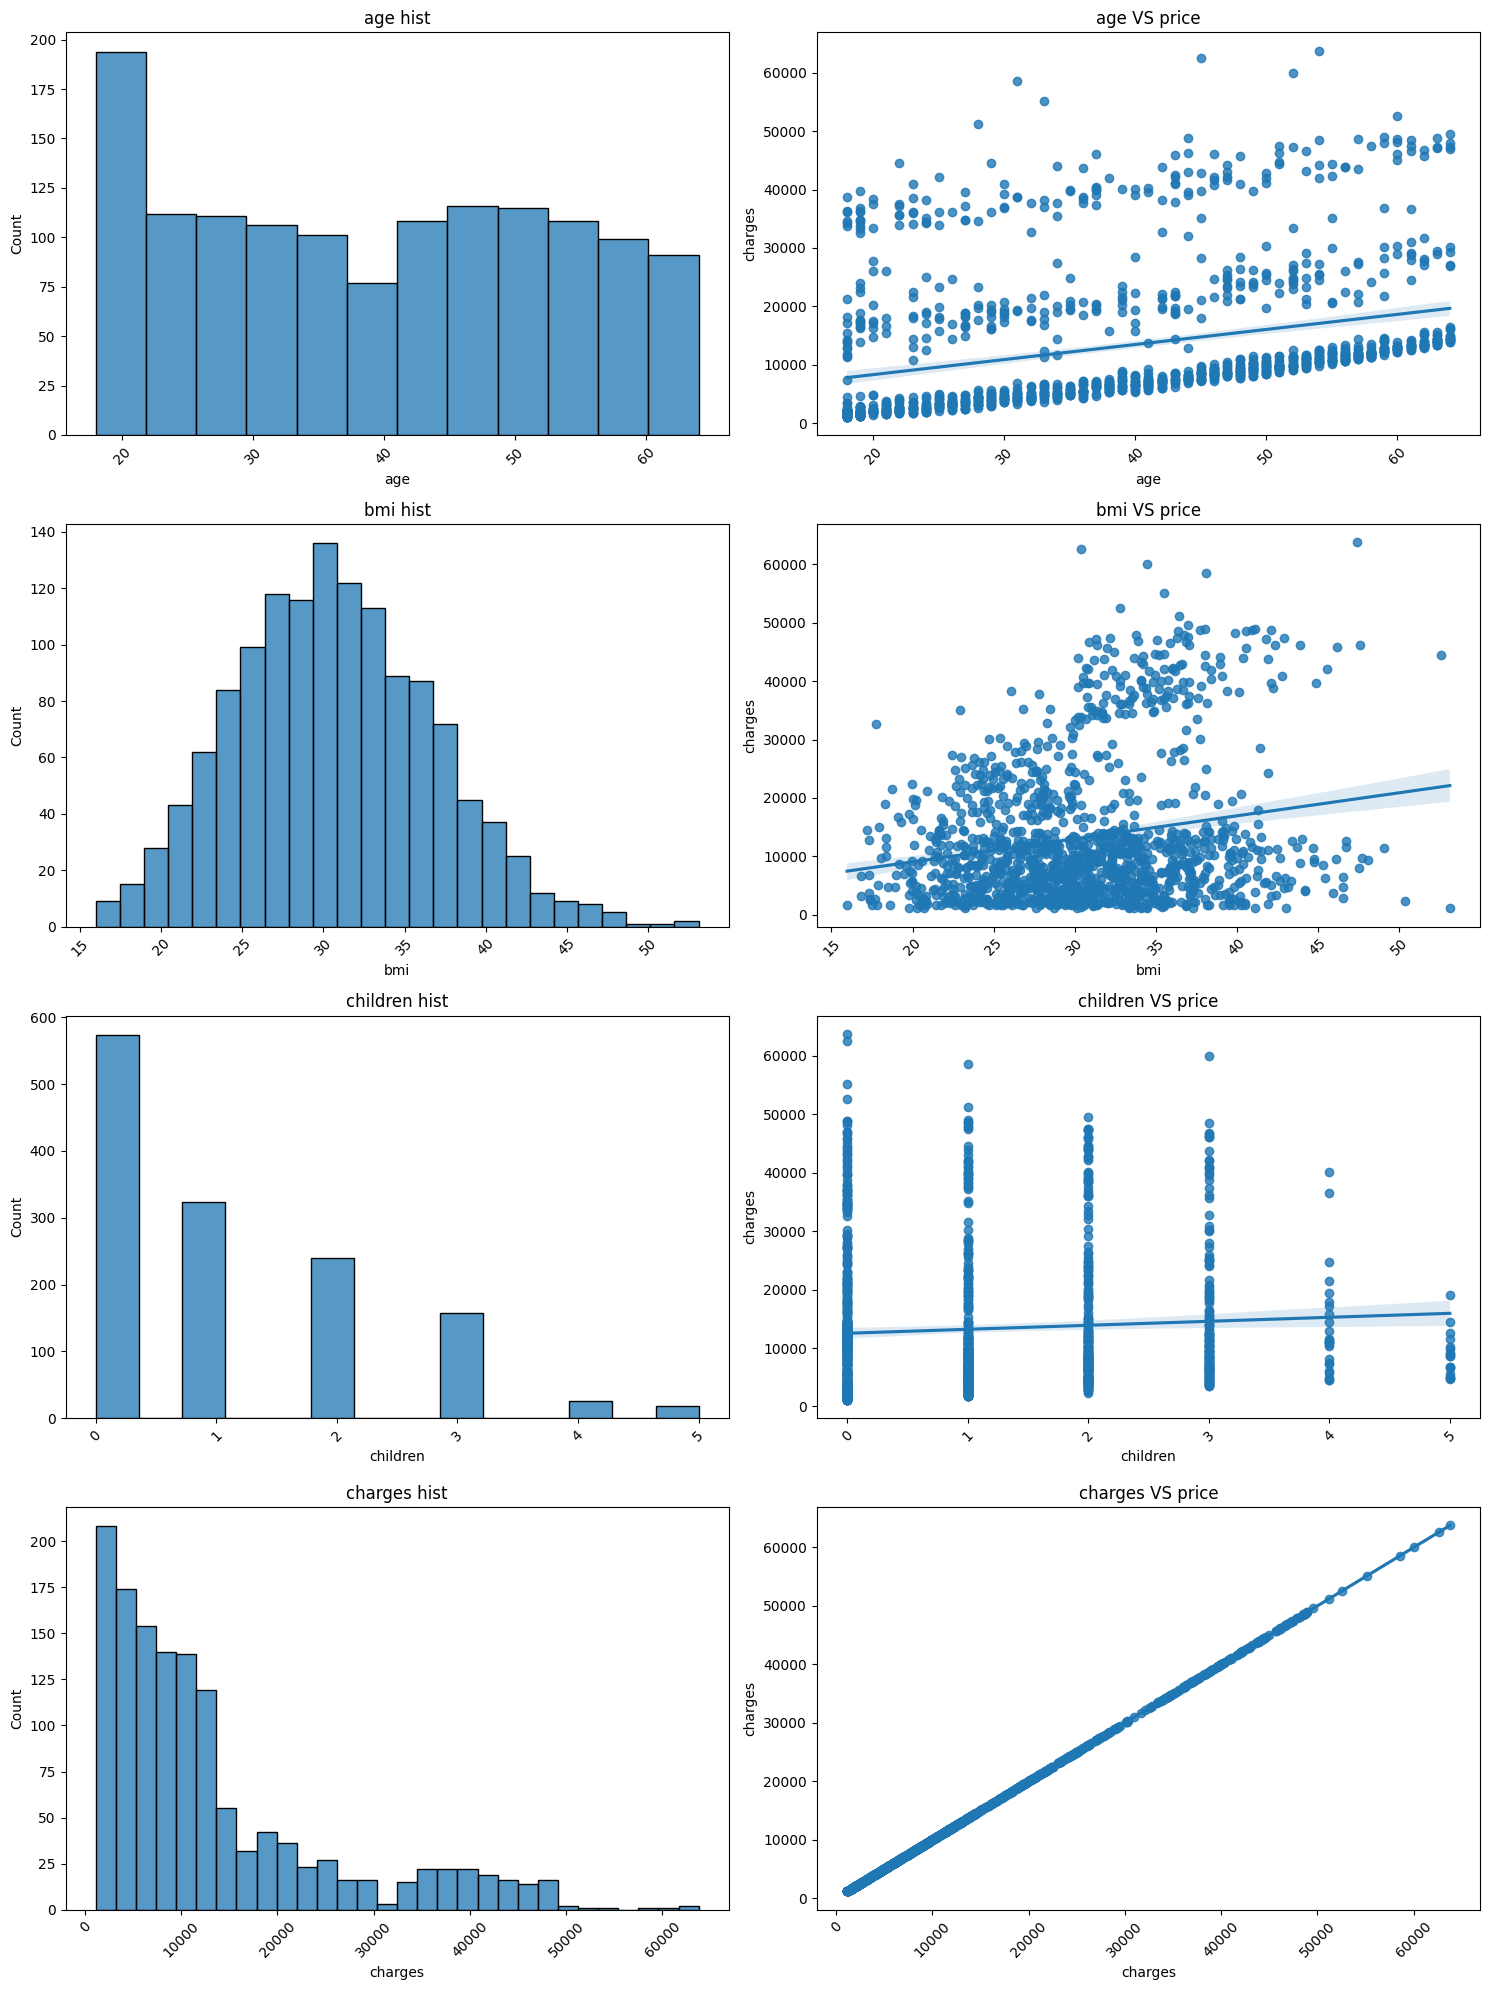

In [47]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Text(0.5, 1.0, 'Зависимость страховки от пола')

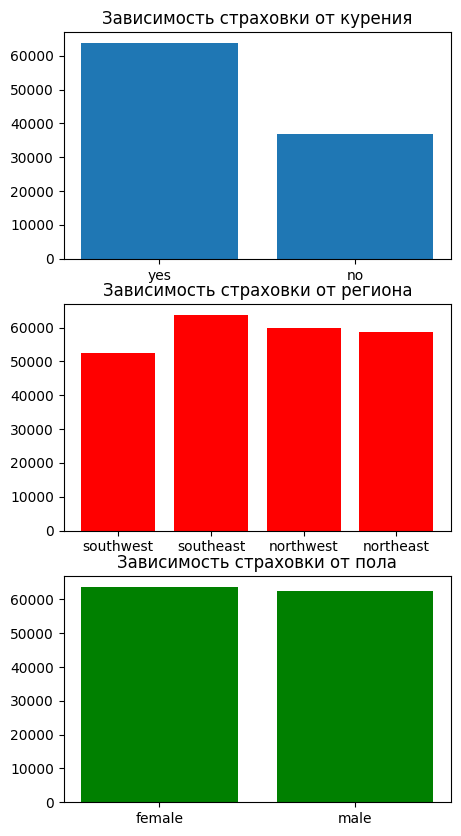

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

axes[0].bar(data['smoker'], data['charges'])
axes[0].set_title('Зависимость страховки от курения')
axes[1].bar(data['region'], data['charges'], color = 'red')
axes[1].set_title('Зависимость страховки от региона')
axes[2].bar(data['sex'], data['charges'], color = 'green')
axes[2].set_title('Зависимость страховки от пола')

In [49]:
import plotly.express as px

pivot = data.pivot_table(
    index='bmi',
    columns='smoker',
    values='charges',
    aggfunc='median',
    fill_value=0)
fig = px.imshow(
    pivot,
    aspect='auto',
    color_continuous_scale='blues',
    title='Зависимость страховки от ИМТ и курения',
    width  = 700)
fig.show()

In [50]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [51]:
# Выделим факторы и целевой признак в отдельные таблицы

features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [52]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [53]:
# функция для метрик

def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [54]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


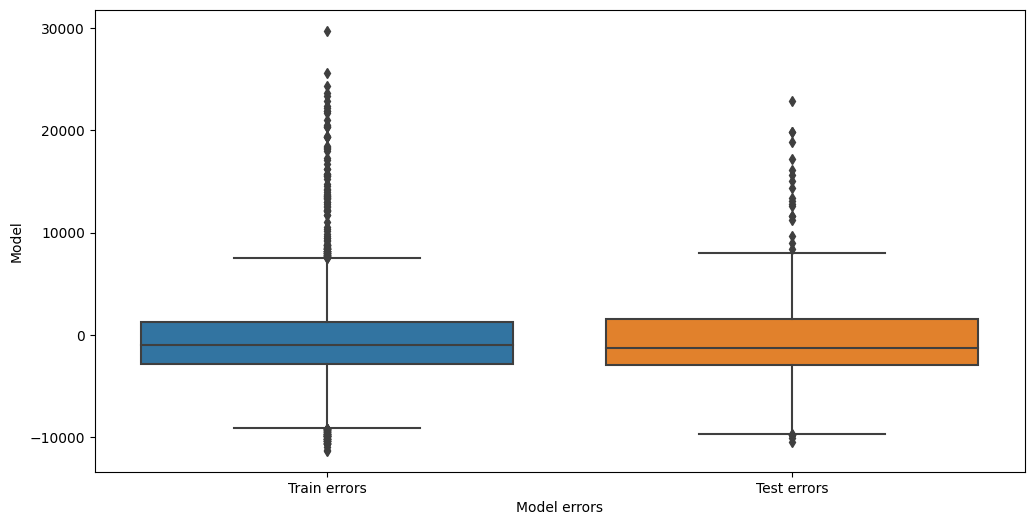

In [55]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [56]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [58]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2912.014
Train MAPE: 29.398


Test R^2: 0.866
Test MAE: 2755.768
Train MAPE: 30.333


In [59]:
# Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

lr_poly.coef_

array([-3.06227002e+16,  1.86235653e+17,  5.08892343e+14,  4.78013503e+15,
        1.28211003e+16, -1.41917221e+16, -6.61624882e+15, -6.95752237e+15,
       -4.20906736e+15,  8.42000000e+03,  8.26000000e+02,  9.40000000e+02,
       -1.67400000e+03,  1.20000000e+02,  3.06227002e+16,  3.06227002e+16,
        3.06227002e+16,  3.06227002e+16, -1.53014624e+17,  7.13750000e+02,
       -1.22287500e+03,  2.17125000e+02, -3.32210291e+16, -3.32210291e+16,
       -3.32210291e+16, -3.32210291e+16, -9.68037500e+03,  1.60443750e+03,
        5.48209531e+04, -5.08892343e+14, -5.08892343e+14, -5.08892343e+14,
       -5.08892343e+14, -2.04800000e+03, -2.23400000e+03, -4.78013503e+15,
       -4.78013503e+15, -4.78013503e+15, -4.78013503e+15, -6.39877451e+15,
       -6.42232583e+15, -6.42232583e+15, -6.42232583e+15, -6.42232583e+15,
       -2.95896241e+15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.05344357e+16,  0.00000000e+00,  0.00000000e+00, -1.01931622e+16,
        0.00000000e+00, -

In [60]:
# Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Lasso(max_iter = 2000)
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрик
print_metrics(y_train, y_train_pred, y_test, y_test_pred)


Train R^2: 0.842
Train MAE: 2912.014
Train MAPE: 29.398


Test R^2: 0.866
Test MAE: 2755.768
Train MAPE: 30.333

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


In [61]:
ridge_lr_poly.coef_

array([ 3.24221653e+03, -4.92313816e+02,  5.07612317e+03,  4.58362056e+03,
        1.97928569e+03,  1.88025707e+02, -4.70775218e+02,  5.83657101e+02,
       -2.43543456e+02,  8.29826751e+03,  7.74581954e+02,  8.44448593e+02,
       -1.20775688e+03,  1.34809915e+02, -1.04309726e+03, -0.00000000e+00,
        1.16964229e+03,  1.61765564e+03, -0.00000000e+00,  5.05847740e+02,
       -1.13425152e+03,  2.65796922e+02, -1.22240479e+03,  0.00000000e+00,
        2.36213242e+02, -5.80031340e+02, -8.17963257e+03,  1.29487768e+03,
        5.47148553e+04,  3.58531873e+03,  2.40690210e+03, -9.63549427e+02,
        0.00000000e+00, -1.67464337e+03, -2.05436459e+03,  1.94204864e+03,
        1.95394442e+03, -0.00000000e+00, -1.06364416e+03,  8.00606774e+00,
        5.93688978e+02, -0.00000000e+00, -2.30643423e+02,  1.97933477e+03,
        6.31615519e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [63]:
# Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обраную функцию - экспоненту
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
